## 🛠 Exercises

1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using [`tf.keras.applications.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) as the base model. Use the [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save the weights to file.
2. Fine-tune the last 20 layers of the base model you trained in 1. for another 10 epochs. How did it go?
3. Fine-tune the last 30 layers of the base model you trained in 1. for another 10 epochs. How did it go?

In [1]:
#libraries for project 
import os
import random

# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np

# View an image and import data analysis tools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

#import tensorflow libraries
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-08-09 21:47:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-09 21:47:25 (101 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Get Data

In [3]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2022-08-09 21:47:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.48, 172.217.1.208, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   218MB/s    in 0.7s    

2022-08-09 21:47:31 (218 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [5]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Architecture:
* Inputs
* `data_augmentation` layer
* Transfer model 
* `GlobalAveragePoolin2S` layer to reduce dimensions of tensor 
* `output` layer with `softmax` activation 

In [6]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=BATCH_SIZE) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  #preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
  ], name ="data_augmentation")

In [9]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Add in data augmentation Sequential model as a layer
inputs_augmented = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
base_model_output = base_model(inputs_augmented, training=False)

# Pool output features of base model
base_pooled_output = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(base_model_output)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(base_pooled_output)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [10]:
# 9. Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
initial_epochs = 10
history_10_percent = model_1.fit(train_data_10_percent,
                                 epochs=initial_epochs,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20220809-214756
Epoch 1/10
24/24 [==============================] - 31s 577ms/step - loss: 1.9916 - accuracy: 0.3427 - val_loss: 1.5282 - val_accuracy: 0.6151
Epoch 2/10
24/24 [==============================] - 11s 427ms/step - loss: 1.4057 - accuracy: 0.6600 - val_loss: 1.1069 - val_accuracy: 0.7632
Epoch 3/10
24/24 [==============================] - 10s 425ms/step - loss: 1.1177 - accuracy: 0.7027 - val_loss: 0.8884 - val_accuracy: 0.7911
Epoch 4/10
24/24 [==============================] - 8s 334ms/step - loss: 0.9695 - accuracy: 0.7400 - val_loss: 0.7941 - val_accuracy: 0.8059
Epoch 5/10
24/24 [==============================] - 9s 346ms/step - loss: 0.8581 - accuracy: 0.7773 - val_loss: 0.7474 - val_accuracy: 0.8043
Epoch 6/10
24/24 [==============================] - 10s 389ms/step - loss: 0.7953 - accuracy: 0.7933 - val_loss: 0.6720 - val_accuracy: 0.8174
Epoch 7/10
24/24 [==============================] 

In [11]:
# Check out model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [13]:
# Evaluate on the test data
results_10_percent_data = model_1.evaluate(test_data_10_percent)
results_10_percent_data

79/79 [==============================] - 6s 76ms/step - loss: 0.5847 - accuracy: 0.8352


[0.5847126841545105, 0.8352000117301941]

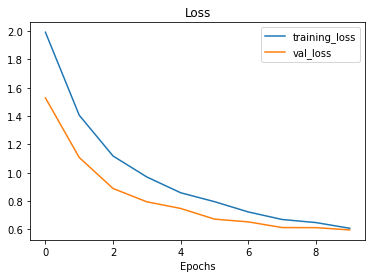

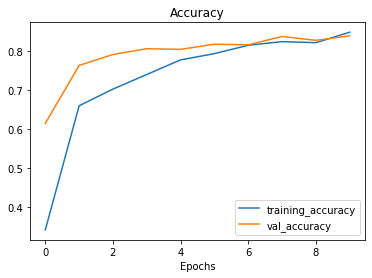

In [14]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Create `ModelCheckpoint` callback

In [15]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [16]:
#save model_1 weights in specified path 
model_1.save_weights(checkpoint_path)

In [17]:
# Load in saved model weights and evaluate model
model_1.load_weights(checkpoint_path)

In [19]:
#Evaluate model_1 with loaded weights
loaded_weights_model_results = model_1.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 72ms/step - loss: 0.5847 - accuracy: 0.8352


In [20]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data == loaded_weights_model_results

False

In [21]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data), np.array(loaded_weights_model_results))

array([ True,  True])

## Fine-tune the last 20 layers 

In [22]:
# Layers in loaded model
model_1.layers

In [23]:
for layer in model_1.layers:
  print(layer.trainable)

True
True
False
True
True


In [24]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [25]:
# How many layers are trainable in our base model?
print(len(model_1.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)

0


In [26]:
print(len(base_model.trainable_variables))

0


In [27]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [29]:
base_model.trainable = True

# Freeze all layers except for the last 20 layers
for layer in base_model.layers[:-20]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [30]:
#save model_1 weights in specified path 
model_1.save_weights(checkpoint_path)

In [31]:
# Load in saved model weights and evaluate model
model_1.load_weights(checkpoint_path)

In [33]:
#Evaluate model_1 with loaded weights
loaded_weights_model_results_1 = model_1.evaluate(test_data_10_percent)

79/79 [==============================] - 8s 73ms/step - loss: 0.5847 - accuracy: 0.8352


In [34]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data == loaded_weights_model_results_1

False

In [36]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data), np.array(loaded_weights_model_results_1))

array([ True,  True])

In [38]:
# Evaluate model (this is the fine-tuned 10 percent of data version with last 20 layers unforzen)
results_10_percent_data_1 = model_1.evaluate(test_data_10_percent)
results_10_percent_data_1

79/79 [==============================] - 6s 71ms/step - loss: 0.5847 - accuracy: 0.8352


[0.5847126841545105, 0.8352000117301941]

In [42]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [43]:
print(len(model_1.trainable_variables))

21


In [44]:
# Fine tune for another 10 epochs
fine_tune_epochs_1 = initial_epochs + 10

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_1 = model_1.fit(train_data_10_percent,
                                           epochs=fine_tune_epochs_1,
                                           validation_data=test_data_10_percent,
                                           initial_epoch=history_10_percent.epoch[-1], # start from previous last epoch
                                           validation_steps=int(0.25 * len(test_data_10_percent)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220809-215742
Epoch 10/20
24/24 [==============================] - 17s 423ms/step - loss: 0.5542 - accuracy: 0.8253 - val_loss: 0.5067 - val_accuracy: 0.8322
Epoch 11/20
24/24 [==============================] - 9s 359ms/step - loss: 0.4481 - accuracy: 0.8533 - val_loss: 0.4648 - val_accuracy: 0.8520
Epoch 12/20
24/24 [==============================] - 8s 329ms/step - loss: 0.3700 - accuracy: 0.9000 - val_loss: 0.5143 - val_accuracy: 0.8322
Epoch 13/20
24/24 [==============================] - 8s 327ms/step - loss: 0.3081 - accuracy: 0.9160 - val_loss: 0.4668 - val_accuracy: 0.8421
Epoch 14/20
24/24 [==============================] - 7s 283ms/step - loss: 0.2854 - accuracy: 0.9160 - val_loss: 0.5058 - val_accuracy: 0.8306
Epoch 15/20
24/24 [==============================] - 7s 299ms/step - loss: 0.2398 - accuracy: 0.9267 - val_loss: 0.4881 - val_accuracy: 0.8536
Epoch 16/20
24/24 [==========================

In [46]:
# Evaluate the model on the test data
results_fine_tune_10_percent_1 = model_1.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 73ms/step - loss: 0.5128 - accuracy: 0.8476


In [47]:
def compare_historys(original_history, new_history, initial_epochs):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Get post fine-tuning history measurements
    new_acc = new_history.history["accuracy"]
    new_loss = new_history.history["loss"]

    new_val_acc = new_history.history["val_accuracy"]
    new_val_loss = new_history.history["val_loss"]

    # Combine original history with post fine-tuning history
    total_acc = acc + new_acc
    total_loss = loss + new_loss

    total_val_acc = val_acc + new_val_acc
    total_val_loss = val_loss + new_val_loss

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy', color="coral")
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning', color='black') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss', color='coral')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning', color='black') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

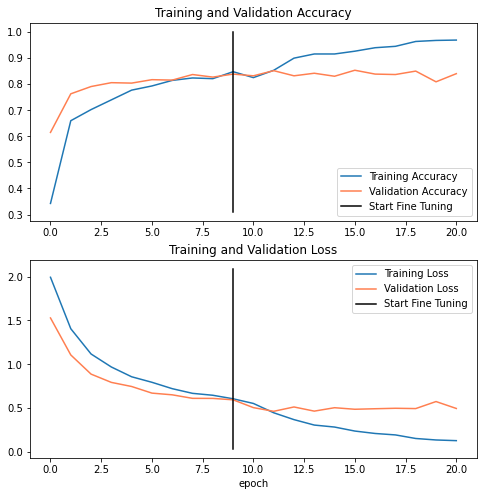

In [48]:
compare_historys(original_history=history_10_percent, 
                 new_history=history_fine_10_percent_data_1, 
                 initial_epochs=10)

## Fine-tune the last 30 layers

In [49]:
# Layers in loaded model
model_1.layers

In [50]:
for layer in model_1.layers:
  print(layer.trainable)

True
True
True
True
True


In [51]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 1,363,770
Non-train

In [52]:
# How many layers are trainable in our base model?
print(len(model_1.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)

19


In [53]:
print(len(base_model.trainable_variables))

19


In [54]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [55]:
base_model.trainable = True

# Freeze all layers except for the last 30 layers
for layer in base_model.layers[:-30]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [56]:
#save model_1 weights in specified path 
model_1.save_weights(checkpoint_path)

In [57]:
# Load in saved model weights and evaluate model
model_1.load_weights(checkpoint_path)

In [58]:
#Evaluate model_1 with loaded weights
loaded_weights_model_results_2 = model_1.evaluate(test_data_10_percent)

79/79 [==============================] - 8s 72ms/step - loss: 0.5128 - accuracy: 0.8476


In [61]:
# If the results from our native model and the loaded weights are the same, this should output True
results_fine_tune_10_percent_1 == loaded_weights_model_results_2

False

In [62]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_fine_tune_10_percent_1), np.array(loaded_weights_model_results_2))

array([ True,  True])

In [63]:
# Evaluate model (this is the fine-tuned 10 percent of data version with last 30 layers unforzen)
model_1.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 71ms/step - loss: 0.5128 - accuracy: 0.8476


[0.5128127932548523, 0.847599983215332]

In [64]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_1.load_weights(checkpoint_path) # revert model back to saved weights

In [65]:
# After loading the weights, this should have gone down (no fine-tuning)
model_1.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 71ms/step - loss: 0.5128 - accuracy: 0.8476


[0.5128127932548523, 0.847599983215332]

In [66]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [67]:
print(len(model_1.trainable_variables))

30


In [68]:
# Fine tune for another 10 epochs
fine_tune_epochs_2 = fine_tune_epochs_1 + 10

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_2 = model_1.fit(train_data_10_percent,
                                            epochs=fine_tune_epochs_2,
                                            validation_data=test_data_10_percent,
                                            initial_epoch=history_fine_10_percent_data_1.epoch[-1], # start from previous last epoch
                                            validation_steps=int(0.25 * len(test_data_10_percent)),
                                            callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220809-220424
Epoch 20/30
24/24 [==============================] - 14s 298ms/step - loss: 0.1353 - accuracy: 0.9640 - val_loss: 0.5072 - val_accuracy: 0.8470
Epoch 21/30
24/24 [==============================] - 7s 269ms/step - loss: 0.1080 - accuracy: 0.9733 - val_loss: 0.5672 - val_accuracy: 0.8257
Epoch 22/30
24/24 [==============================] - 9s 346ms/step - loss: 0.0825 - accuracy: 0.9813 - val_loss: 0.5667 - val_accuracy: 0.8355
Epoch 23/30
24/24 [==============================] - 7s 276ms/step - loss: 0.0759 - accuracy: 0.9800 - val_loss: 0.5655 - val_accuracy: 0.8306
Epoch 24/30
24/24 [==============================] - 7s 290ms/step - loss: 0.0804 - accuracy: 0.9800 - val_loss: 0.5944 - val_accuracy: 0.8059
Epoch 25/30
24/24 [==============================] - 8s 320ms/step - loss: 0.0622 - accuracy: 0.9853 - val_loss: 0.5588 - val_accuracy: 0.8388
Epoch 26/30
24/24 [==========================

In [75]:
# Evaluate the model on the test data
results_fine_tune_10_percent_2 = model_1.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 70ms/step - loss: 0.5496 - accuracy: 0.8528


# Visualization Function

* Function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [81]:
# Creating a function that would grab the image from a dataset, visualize and gives the prediction of it. 

def dataset_visualizer(dataset , model):
  '''
  Arguments: 
    dataset --> `tf.data.Dataset` object with (image , label) tuples 
    model --> the trained model 

  Returns: 
    Visualizae the image from the dataset and the prediction class of the image. 
  '''
  image_batch , label_batch = dataset.as_numpy_iterator().next() 
  batch_prob = [model.predict(tf.expand_dims(img , axis = 0)) for img in image_batch]
  batch_preds = [dataset.class_names[np.argmax(prob)] for prob in batch_prob]

  plt.figure(figsize= (10 , 10))
  for i in range(4):
    ax = plt.subplot(2 , 2 , i + 1)
    if dataset.class_names[np.argmax(label_batch[i])] == batch_preds[i]:
      title_color = 'g'
    else:
      title_color = 'r'
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(f"actual: {dataset.class_names[np.argmax(label_batch[i])]}, pred: {batch_preds[i]}, prob: {batch_prob[i].max():.2f}" , c = title_color)
    plt.axis('off')

In [78]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

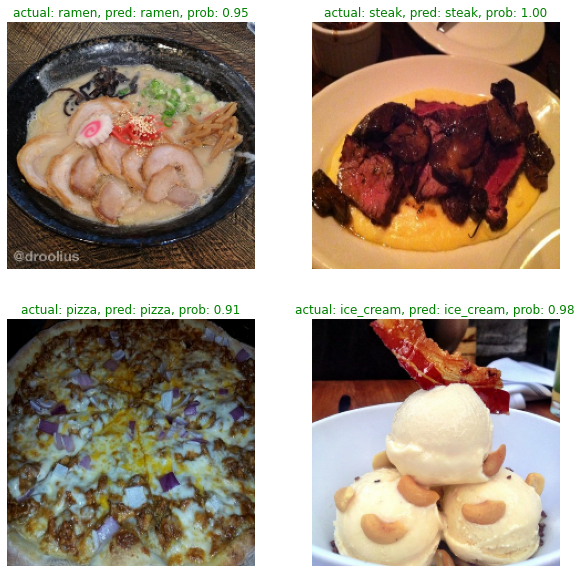

In [85]:
dataset_visualizer(test_data_10_percent , model_1)